<div align="center">
  <img src="VENDOR_PERFO.png" alt="Vendor Performance Analysis" width="700" style="border: 1px solid #ccc; border-radius: 10px; padding: 5px;">
  <div style="margin-top: 10px; font-weight: bold; font-size: 16px; color: #444;">
  </div>
</div>

    This project focuses on analyzing vendor performance using inventory, purchase, sales and vendor invoice dataset.
    The objective is to identify top vendors, total sales, total purchase, analyze cost metrics like Stock turnover, Sales purchase ratio, freight summary and unsold capital. Evaluate profit margins, gross profit pto drive better business decisions.

## Schema Design

| Column | Type | Description | Source Tables |
|--------|------|-------------|---------------|
| **VendorNumber** | INT | Unique vendor identifier | purchases, vendors |
| **VendorName** | VARCHAR(100) | Vendor business name | vendors |
| **Brand** | INT | Product brand ID | purchases, sales |
| **Description** | VARCHAR(100) | Product description | products |
| **PurchasePrice** | DECIMAL(10,2) | Actual paid price per unit | purchases |
| **ActualPrice** | DECIMAL(10,2) | Standard reference price | purchase_prices |
| **Volume** | INT | Transaction volume | purchase_prices |
| **TotalPurchasedQuantity** | INT | Aggregate units bought | purchases |
| **TotalPurchasedDollars** | DECIMAL(15,2) | Total spend amount | purchases |
| **TotalSalesQuantity** | INT | Aggregate units sold | sales |
| **TotalSalesDollars** | DECIMAL(15,2) | Gross revenue | sales |
| **TotalSalesPrice** | DECIMAL(15,2) | Total selling price | sales |
| **TotalExciseTax** | DECIMAL(15,2) | Total tax burden | sales |
| **FreightCost** | DECIMAL(15,2) | Shipping expenses | vendor_invoice |
| **GrossProfit** | DECIMAL(15,2) | Revenue minus costs | Calculated |
| **ProfitMargin** | DECIMAL(15,2) | Profit percentage | Calculated |
| **StockTurnover** | DECIMAL(15,2) | Inventory velocity | Calculated |
| **SalesToPurchaseRatio** | DECIMAL(15,2) | Demand vs supply ratio | Calculated |

## Key Insights
     - Identify top vendors by sales and profit.
     - Identify top Brands by sales and profit.
     - Analyze Brands to recommend promotions or pricing changes
     - Evaluate cost contributors like freight and sales.
     - Calculate and compare profit margins and gross profit across brands.
     - Visualize results in Power BI dashboards for stakeholders.

In [1]:
# import libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
import sqlite3

from scipy.stats import ttest_ind 
import scipy.stats as stats 

Matplotlib is building the font cache; this may take a moment.


In [3]:
# loading the dataset 
conn = sqlite3.connect('inventory.db')

# fetching vendor summary data 
df = pd.read_sql_query("SELECT * FROM vendor_sales_summary", conn)
df.head(5)

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5.101920e+06,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4.819073e+06,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,187140.0,4.538121e+06,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,200412.0,4.475973e+06,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,135838.0,4.223108e+06,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897


### Exploratory Data Analysis (EDA) Overview

#### **Previous Steps:**
- Examined database tables to:
  - Identify key variables
  - Understand relationships between variables
  - Determine which variables to include in final analysis

#### **Current Phase:**
- Analyzing the resultant table to:
  - Study column distributions
  - Identify data patterns and trends
  - Detect anomalies and outliers
  - Verify data quality before deeper analysis

#### **Next Steps:**
- Perform statistical summaries (e.g., `.describe()`)
- Create visualizations (histograms, boxplots)
- Check for missing values and data inconsistencies

In [4]:
# summary statistics 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,10650.649458,18753.519148,2.000000,3951.000000,7153.000000,9552.000000,2.013590e+05
Brand,10692.0,18039.228769,12662.187074,58.000000,5793.500000,18761.500000,25514.250000,9.063100e+04
PurchasePrice,10692.0,24.385303,109.269375,0.360000,6.840000,10.455000,19.482500,5.681810e+03
ActualPrice,10692.0,35.643671,148.246016,0.490000,10.990000,15.990000,28.990000,7.499990e+03
Volume,10692.0,847.360550,664.309212,50.000000,750.000000,750.000000,750.000000,2.000000e+04
TotalPurchaseQuantity,10692.0,3140.886831,11095.086769,1.000000,36.000000,262.000000,1975.750000,3.376600e+05
TotalPurchaseDollars,10692.0,30106.693372,123067.799627,0.710000,453.457500,3655.465000,20738.245000,3.811252e+06
TotalSalesQuantity,10692.0,3077.482136,10952.851391,0.000000,33.000000,261.000000,1929.250000,3.349390e+05
TotalSalesDollars,10692.0,42239.074419,167655.265984,0.000000,729.220000,5298.045000,28396.915000,5.101920e+06
TotalSalesPrice,10692.0,18793.783627,44952.773386,0.000000,289.710000,2857.800000,16059.562500,6.728193e+05


In [5]:
# Distribution plots for Numerical columns 
numerical_cols = df.select_dtypes(include=np.number).columns # shows the total numerical columns 

In [6]:
numerical_cols

Index(['VendorNumber', 'Brand', 'PurchasePrice', 'ActualPrice', 'Volume',
       'TotalPurchaseQuantity', 'TotalPurchaseDollars', 'TotalSalesQuantity',
       'TotalSalesDollars', 'TotalSalesPrice', 'TotalExciseTax', 'FreightCost',
       'GrossProfit', 'ProfitMargin', 'StockTurnover', 'SalesToPurchaseRatio'],
      dtype='object')

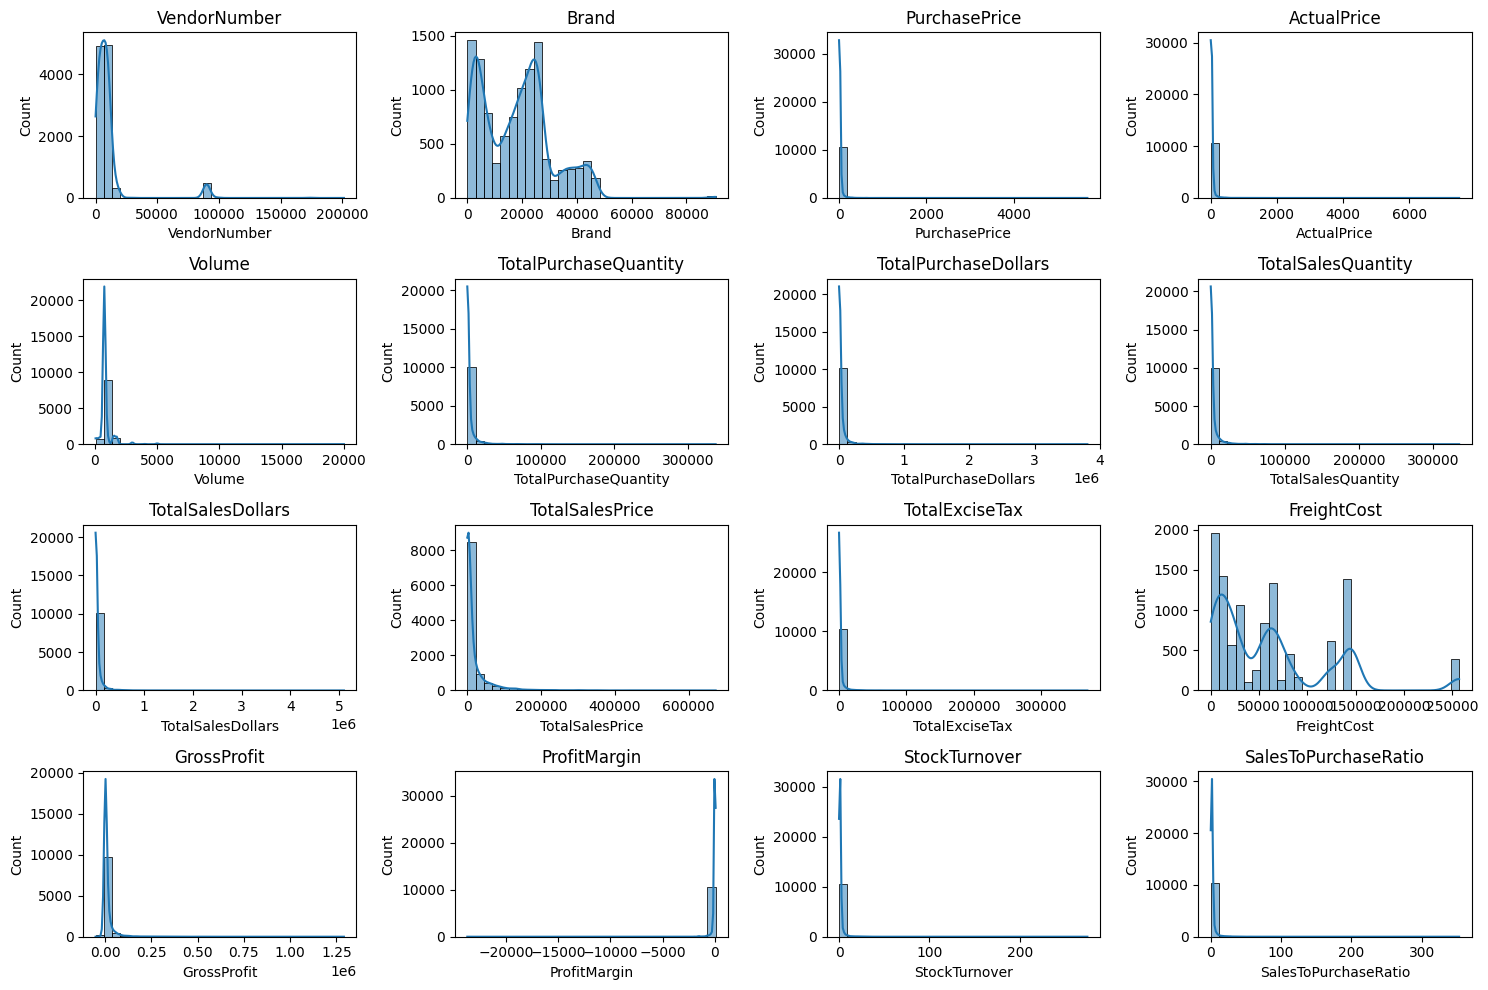

In [6]:
# use this code to visualize the distribution of multiple numerical columns in a dataset using histograms (with optional KDE lines)
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i + 1)  # 4x4 grid — adjust based on number of columns
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)

plt.tight_layout()
plt.show()

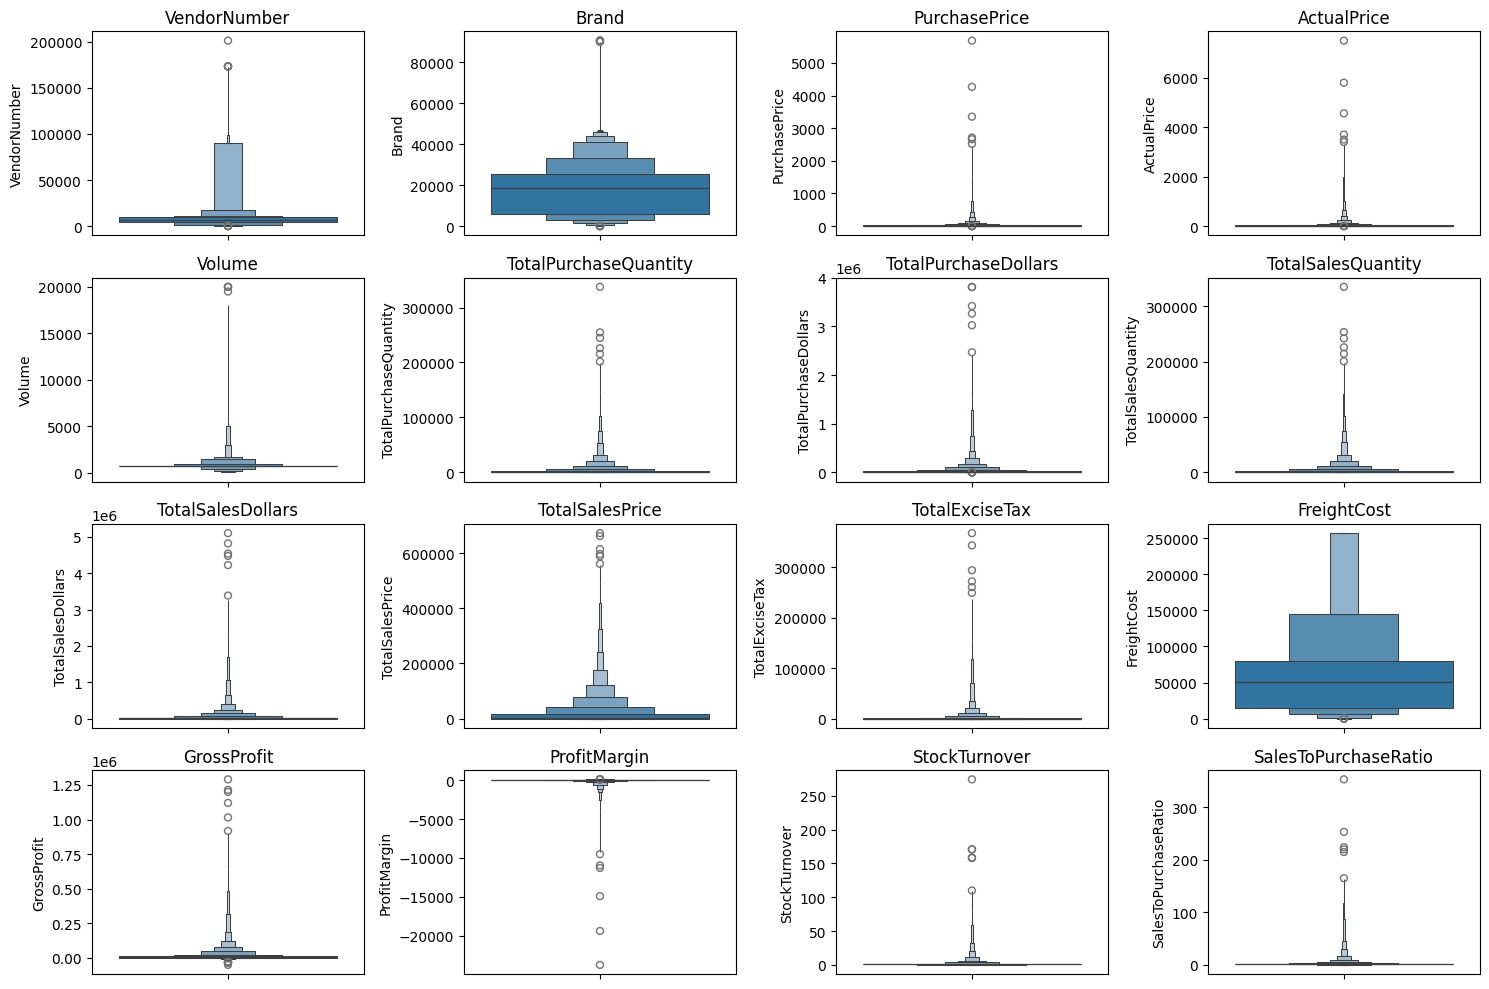

In [7]:
# Outlier Detection with BoxPlot 
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i + 1)  # 4x4 grid — adjust based on number of columns
    sns.boxenplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

### Summary Statistics Insights

#### **Negative & Zero Values:**
- **Gross Profit**:  
  - Minimum value: -52,002.78  
  - **Insight**: Indicates losses, likely due to high costs or selling at discounts below purchase price.  

- **Profit Margin**:  
  - Minimum value: ~∞  
  - **Insight**: Occurs when revenue is zero or negative (costs exceed revenue).  

- **Total Sales Quantity & Sales Dollars**:  
  - Minimum values: 0  
  - **Insight**: Some products were purchased but never sold, suggesting slow-moving or obsolete stock.  

---

#### **Outliers Indicated by High Standard Deviations:**
- **Purchase & Actual Prices**:  
  - Max values: 5,681.81 (Purchase), 7,499.99 (Actual)  
  - Mean values: 24.39 (Purchase), 35.64 (Actual)  
  - **Insight**: Significant disparity suggests presence of premium/high-value products.  

- **Freight Cost**:  
  - Range: 0.09 to 257,032.07  
  - **Insight**: Extreme variation may indicate logistics inefficiencies or bulk shipments.  

- **Stock Turnover**:  
  - Range: 0 to 274.5  
  - **Insight**:  
    - 0: Products not selling (stock remains indefinitely).  
    - >1: Sold quantity exceeds purchased quantity (fulfilled from older stock).  
    - 274.5: Extremely fast-selling products.  

In [8]:
# let's filter the data by removing inconsistencies 
df = pd.read_sql_query("""
    SELECT * FROM vendor_sales_summary
    WHERE GrossProfit > 0
    AND ProfitMargin > 0
    AND TotalSalesQuantity > 0""", conn)

In [9]:
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5.101920e+06,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4.819073e+06,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,187140.0,4.538121e+06,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,200412.0,4.475973e+06,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,135838.0,4.223108e+06,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8560,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2,2.64,5.0,1.595000e+01,10.96,0.55,27100.41,13.31,83.448276,2.500000,6.041667
8561,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6,2.34,134.0,6.566000e+01,1.47,7.04,50293.62,63.32,96.436186,22.333333,28.059829
8562,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,0.74,0.99,50.0,2,1.48,2.0,1.980000e+00,0.99,0.10,14069.87,0.50,25.252525,1.000000,1.337838
8563,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,1.99,200.0,1,1.47,72.0,1.432800e+02,77.61,15.12,257032.07,141.81,98.974037,72.000000,97.469388


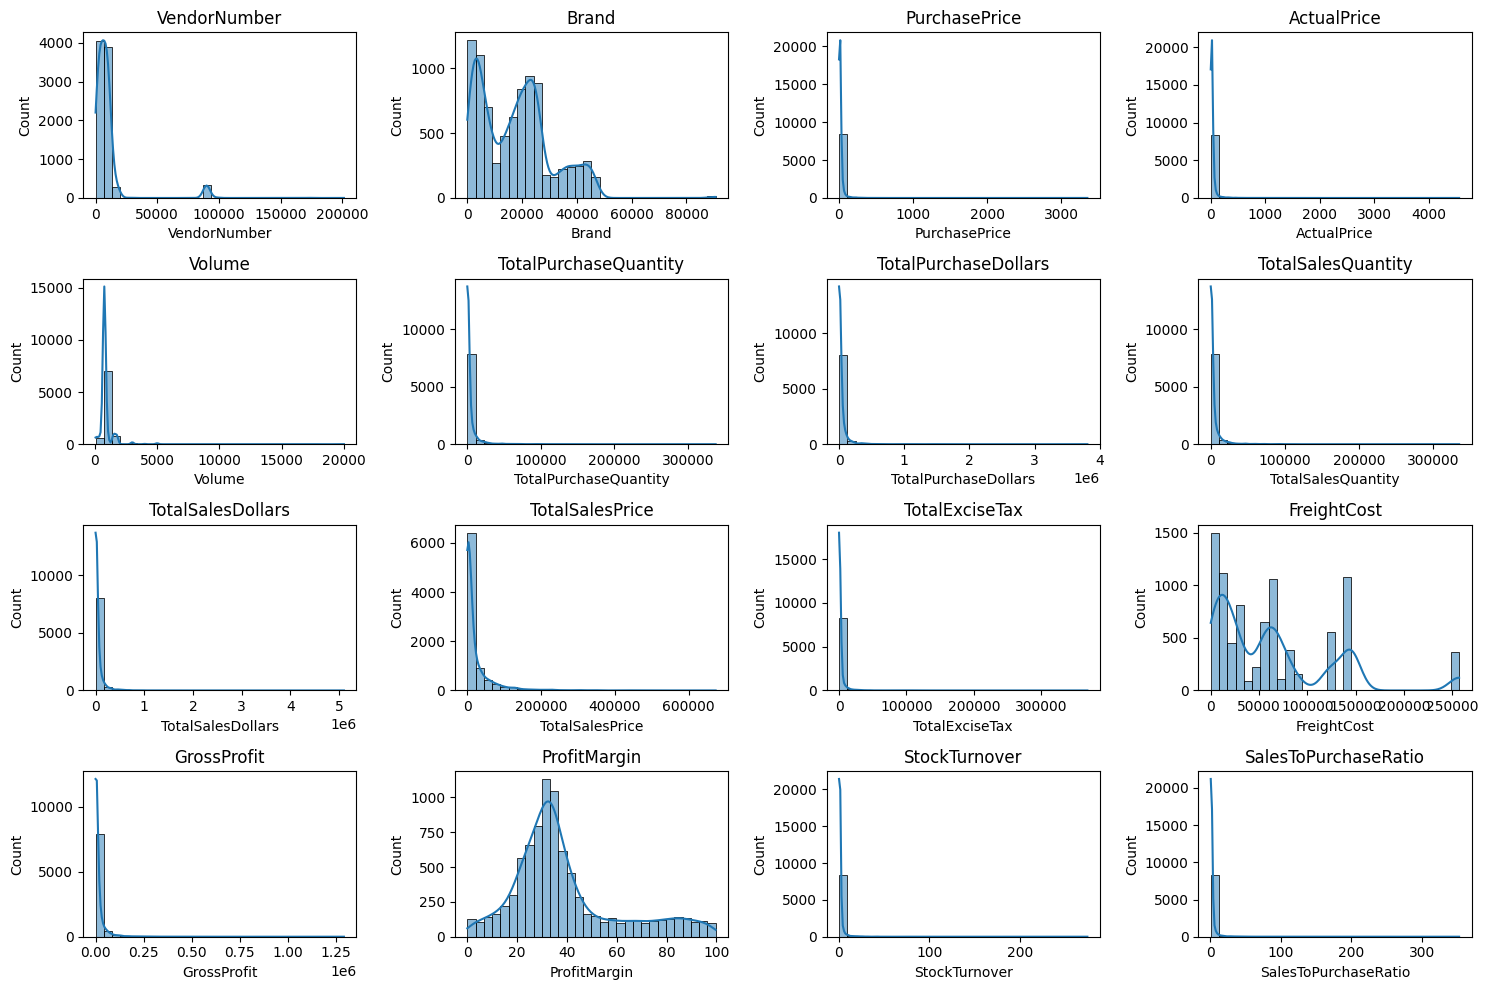

In [10]:
# Plot the distribution plot after cleaning the data 
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i + 1)  # 4x4 grid — adjust based on number of columns
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)

plt.tight_layout()
plt.show()

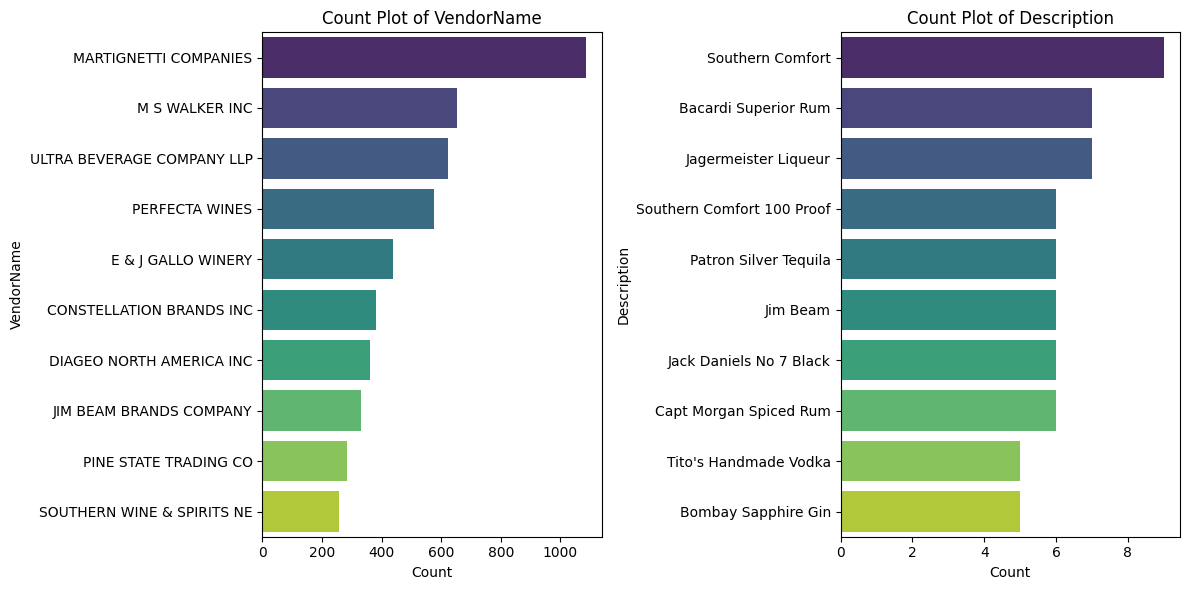

In [11]:
categorical_cols = ["VendorName", "Description"]
plt.figure(figsize=(12, 6))

for i, col in enumerate(categorical_cols):
    plt.subplot(1, 2, i + 1)  # Adjust this if you have more than 2 columns
    sns.countplot(
        y=df[col],
        order=df[col].value_counts().index[:10],  # Top 10 categories
        palette="viridis"  # You can change this to "Set2", "pastel", etc.
    )
    plt.title(f"Count Plot of {col}")
    plt.xlabel("Count")
    plt.ylabel(col)

plt.tight_layout()
plt.show()

Above visualization presents the **top 10 most frequent values** for the categorical columns `VendorName` and `Description` using horizontal count plots.

### Visual Summary

#### **Top 10 Vendors (Left Plot)**
- Most frequent vendor: **MARTIGNETTI COMPANIES**
- Other top vendors include:
  - M S WALKER INC
  - ULTRA BEVERAGE COMPANY LLP
  - PERFECTA WINES
- This plot helps identify major suppliers based on transaction volume.

#### **Top 10 Products (Right Plot)**
- Most popular product: **Southern Comfort**
- Other high-frequency items:
  - Bacardi Superior Rum
  - Jagermeister Liqueur
  - Patron Silver Tequila
- Useful for demand forecasting and stock planning.

---

### Insights
- These plots offer a quick glance at the **most active vendors** and **most sold products**.
- Can support strategic decisions in:
  - Procurement
  - Marketing
  - Inventory Management

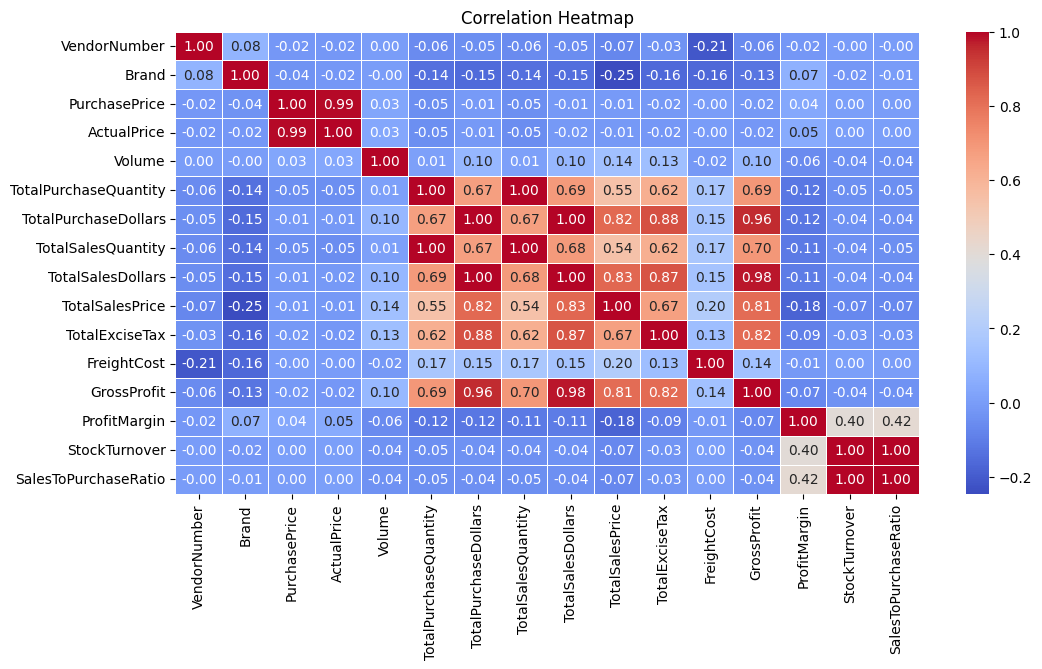

In [12]:
# Correlation HeatMap 
plt.figure(figsize=(12, 6))
correlation_matrix = df[numerical_cols].corr() 
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### Correlation Insights

#### **Key Findings:**
- **Purchase Price Relationships:**
  - Weak correlation with TotalSalesDollars (-0.012)  
  - Weak correlation with GrossProfit (-0.016)  
  - **Interpretation**: Price variations have minimal impact on sales revenue or profit.  

- **Inventory Efficiency:**
  - Very strong correlation (0.999) between TotalPurchaseQuantity and TotalSalesQuantity  
  - **Interpretation**: Near-perfect inventory turnover, indicating purchases align closely with sales.  

- **Profit Margin Dynamics:**
  - Negative correlation (-0.179) between ProfitMargin and TotalSalesPrice  
  - **Interpretation**: Higher sales prices correlate with lower margins, likely due to competitive pricing strategies.  

- **Stock Turnover Impact:**
  - Weak negative correlation with GrossProfit (-0.038)  
  - Weak negative correlation with ProfitMargin (-0.055)  
  - **Interpretation**: Faster stock turnover does not directly translate to higher profitability.  

---

#### **Suggested Actions:**
1. Investigate pricing strategies for high-sales-price items to improve margins.  
2. Maintain current inventory practices given their efficiency.  
3. Explore why faster stock turnover doesn’t boost profits (e.g., discounting, operational costs).  

### Data Analysis - Bussiness Problem

### Business Problem 1: Identify Underperforming Brands with High Profit Margins

#### **Objective**:
Identify brands that require promotional or pricing adjustments due to:
- **Low sales performance** (underperforming in market penetration)
- **High profit margins** (indicating pricing power or cost efficiency)

In [13]:
### Brand Performance Analysis
# Group data by product Description to analyze brand performance metrics
brand_performance = df.groupby('Description').agg({
    'TotalSalesDollars':'sum',       # Calculate total sales revenue per brand
    'ProfitMargin':'mean'            # Calculate average profit margin per brand
}).reset_index()                     # Reset index to convert Description back to a column

# Resulting DataFrame contains:
# - Description: Brand/product names
# - TotalSalesDollars: Cumulative sales for each brand
# - ProfitMargin: Average margin percentage for each brand

In [14]:
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.85) 

In [15]:
low_sales_threshold

np.float64(560.299)

In [16]:
high_margin_threshold

np.float64(64.97017552750111)

In [17]:
# filter brands with low sales but high profit margins 
# Filter brands with low sales but high profit margins
target_brands = brand_performance[
    (brand_performance['TotalSalesDollars'] < low_sales_threshold) &
    (brand_performance['ProfitMargin'] > high_margin_threshold)
] 
print("Brands with low Sales but High Profit Margins:")
display(target_brands.sort_values('TotalSalesDollars'))

Brands with low Sales but High Profit Margins:


,Description,TotalSalesDollars,ProfitMargin
6199,Santa Rita Organic Svgn Bl,9.99,66.466466
2369,Debauchery Pnt Nr,11.58,65.975820
2070,Concannon Glen Ellen Wh Zin,15.95,83.448276
2188,Crown Royal Apple,27.86,89.806174
6237,Sauza Sprklg Wild Berry Marg,27.96,82.153076
...,...,...,...
5074,Nanbu Bijin Southern Beauty,535.68,76.747312
2271,Dad's Hat Rye Whiskey,538.89,81.851584
57,A Bichot Clos Marechaudes,539.94,67.740860
6245,Sbragia Home Ranch Merlot,549.75,66.444748


In [18]:
brand_performance = brand_performance[brand_performance['TotalSalesDollars'] < 10000] # for better visualization

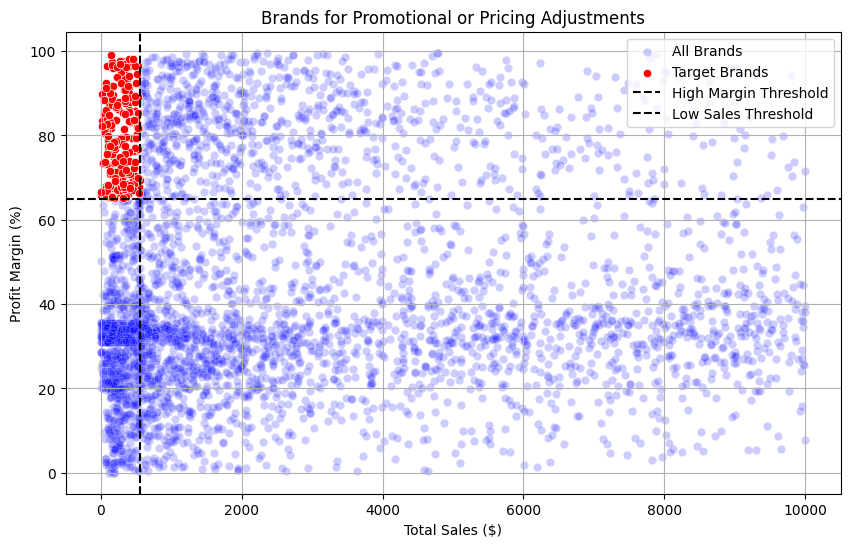

In [19]:
plt.figure(figsize=(10, 6))

# All brands (blue, transparent)
sns.scatterplot(
    data=brand_performance, 
    x='TotalSalesDollars', 
    y='ProfitMargin', 
    color="blue", 
    label="All Brands", 
    alpha=0.2
)

# Target brands (red)
sns.scatterplot(
    data=target_brands, 
    x='TotalSalesDollars', 
    y='ProfitMargin', 
    color="red", 
    label="Target Brands"
)

# Threshold lines
plt.axhline(high_margin_threshold, linestyle='--', color='black', label="High Margin Threshold")
plt.axvline(low_sales_threshold, linestyle='--', color='black', label="Low Sales Threshold")

# Labels and formatting
plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()



### Business Problem 2: Identify Top-Performing Vendors and Brands

#### **Objective**:
Identify which vendors and brands demonstrate:
- Highest sales volume (quantity)
- Highest revenue generation (dollar value)
- Strongest market performance

In [20]:
def format_dollars(value):
    if value >= 1_000_000:
        return f"{value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value / 1_000:.2f}K"
    else:
        return str(value)

In [21]:
# top vendor and Bands by sales performance 
top_vendors = df.groupby("VendorName")["TotalSalesDollars"].sum().nlargest(10)
top_brands = df.groupby("Description")["TotalSalesDollars"].sum().nlargest(10)

In [22]:
# top_vendors

In [23]:
# top_brands

In [24]:
top_brands.apply(lambda x: format_dollars(x))

Description
Jack Daniels No 7 Black    7.96M
Tito's Handmade Vodka      7.40M
Grey Goose Vodka           7.21M
Capt Morgan Spiced Rum     6.36M
Absolut 80 Proof           6.24M
Jameson Irish Whiskey      5.72M
Ketel One Vodka            5.07M
Baileys Irish Cream        4.15M
Kahlua                     3.60M
Tanqueray                  3.46M
Name: TotalSalesDollars, dtype: object

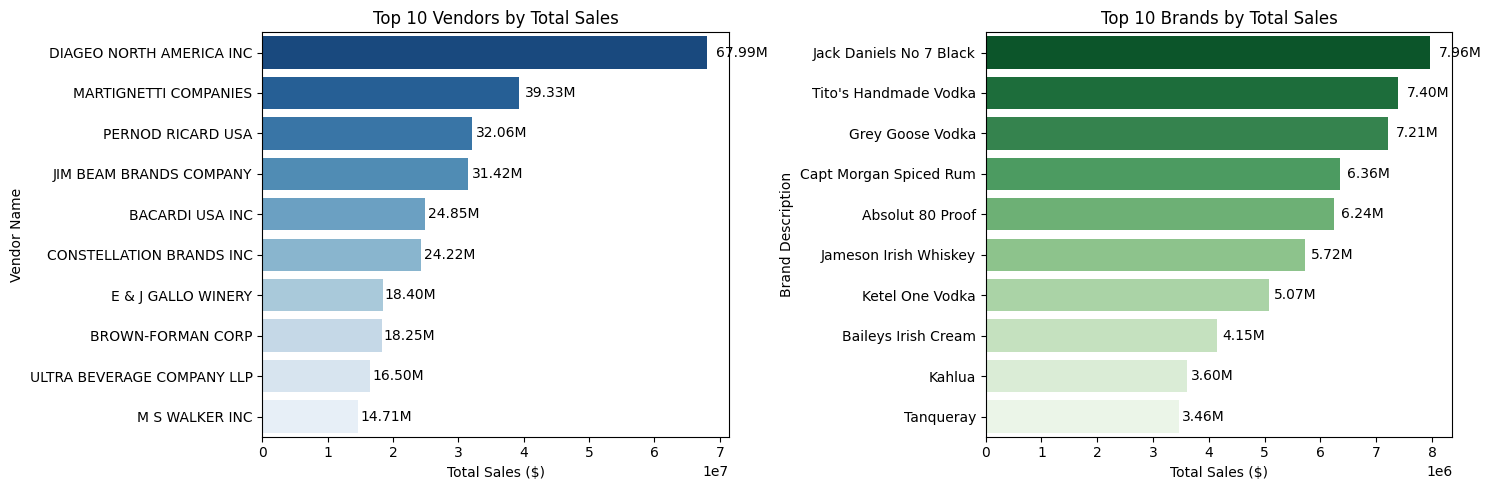

In [25]:
plt.figure(figsize=(15, 5))

# --- Plot for Top Vendors ---
plt.subplot(1, 2, 1)
ax1 = sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r")
plt.title("Top 10 Vendors by Total Sales")
plt.xlabel("Total Sales ($)")
plt.ylabel("Vendor Name")

# Add labels on bars
for bar in ax1.patches:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    ax1.text(
        width + (width * 0.02),
        y_pos,
        format_dollars(width),
        ha='left', va='center', fontsize=10, color='black'
    )

# --- Plot for Top Brands ---
plt.subplot(1, 2, 2)
ax2 = sns.barplot(y=top_brands.index, x=top_brands.values, palette="Greens_r")
plt.title("Top 10 Brands by Total Sales")
plt.xlabel("Total Sales ($)")
plt.ylabel("Brand Description")

# Add labels on bars
for bar in ax2.patches:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    ax2.text(
        width + (width * 0.02),
        y_pos,
        format_dollars(width),
        ha='left', va='center', fontsize=10, color='black'
    )

# Final layout
plt.tight_layout()
plt.show()

### Business Problem 3: Which vendors contribute the most to total purchase dollar?

In [26]:
vendor_performance = df.groupby('VendorName').agg({
    'TotalPurchaseDollars': sum, 
    'GrossProfit': sum, 
    'TotalSalesDollars': sum 
}).reset_index()
vendor_performance.shape  # we have 119 vendors 

(119, 4)

In [27]:
# How much the contribution of each vendor towards purchase 
vendor_performance['Purchase_Contribution%'] = vendor_performance['TotalPurchaseDollars'] / vendor_performance['TotalPurchaseDollars'].sum()*100

In [28]:
vendor_performance = round(vendor_performance.sort_values('Purchase_Contribution%', ascending= False), 2)

In [29]:
# Get top 10 vendors
top_vendors = vendor_performance.head(10)

top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(format_dollars)

top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,Purchase_Contribution%
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64
6,BACARDI USA INC,17.43M,7.42M,24.85M,5.67
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,4.97
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,4.31
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,3.93
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,3.63
53,M S WALKER INC,9.76M,4.94M,14.71M,3.18


In [30]:
top_vendors['Purchase_Contribution%'].sum()

np.float64(65.69000000000001)

In [31]:
top_vendors['Cumulative_Contribution%'] = top_vendors['Purchase_Contribution%'].cumsum()
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,Purchase_Contribution%,Cumulative_Contribution%
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30,16.30
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30,24.60
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76,32.36
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64,40.00
6,BACARDI USA INC,17.43M,7.42M,24.85M,5.67,45.67
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,4.97,50.64
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,4.31,54.95
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,3.93,58.88
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,3.63,62.51
53,M S WALKER INC,9.76M,4.94M,14.71M,3.18,65.69


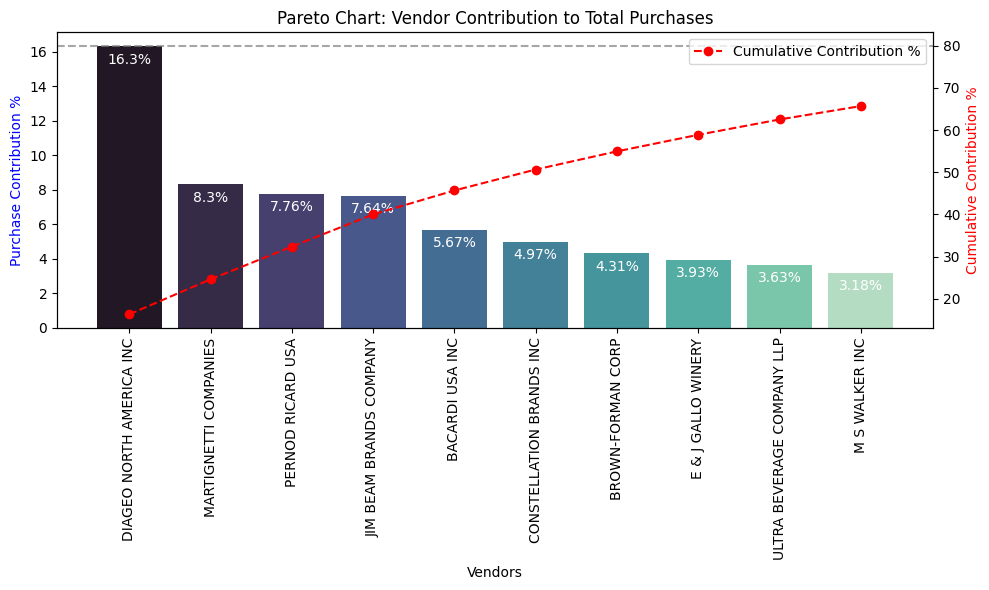

In [32]:
# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Purchase Contribution %
sns.barplot(
    x=top_vendors['VendorName'],
    y=top_vendors['Purchase_Contribution%'],
    palette="mako",
    ax=ax1
)

# Add value labels on bars
for i, value in enumerate(top_vendors['Purchase_Contribution%']):
    ax1.text(i, value - 1, str(value)+'%', ha='center', fontsize=10, color='white')

# Create secondary axis for cumulative % line
ax2 = ax1.twinx()
ax2.plot(
    top_vendors['VendorName'],
    top_vendors['Cumulative_Contribution%'],
    color='red',
    marker='o',
    linestyle='dashed',
    label='Cumulative Contribution %'
)

# Customize axes and labels
ax1.tick_params(axis='x', rotation=90)  # Fix rotation properly
ax1.set_ylabel('Purchase Contribution %', color='blue')
ax2.set_ylabel('Cumulative Contribution %', color='red')
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto Chart: Vendor Contribution to Total Purchases')

# Add horizontal line at 80% to mark Pareto threshold
ax2.axhline(y=80, color='gray', linestyle='dashed', alpha=0.7)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Business Problem 4: How much of total procurement is dependent on the top vendors ?

In [33]:
print(f"Total Purchase Contribution of top 10 vendor is {round(top_vendors['Purchase_Contribution%'].sum(),2)} %")

Total Purchase Contribution of top 10 vendor is 65.69 %


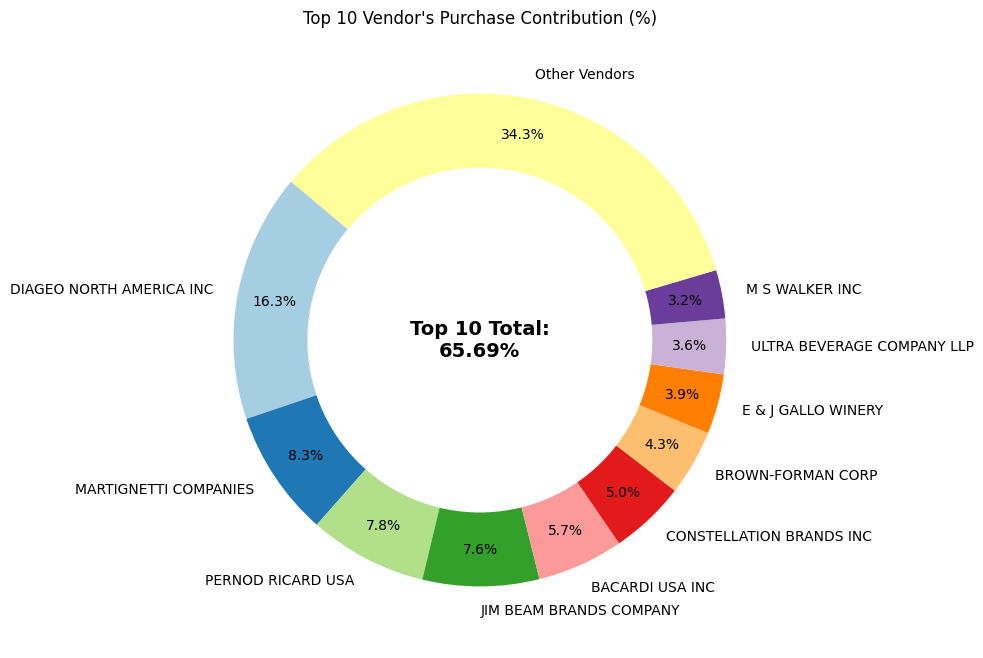

In [34]:
vendors = list(top_vendors['VendorName'].values)
purchase_contributions = list(top_vendors['Purchase_Contribution%'].values)
total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

# Append "Other Vendors" category
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)

# Donut Chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(purchase_contributions, labels=vendors, autopct='%1.1f%%',
                                  startangle=140, pctdistance=0.85, colors=plt.cm.Paired.colors)

# Draw a white circle in the center to create a "donut" effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add Total Contribution annotation in the center
plt.text(0, 0, f"Top 10 Total:\n{total_contribution:.2f}%", fontsize=14, fontweight='bold',
         ha='center', va='center')

plt.title("Top 10 Vendor's Purchase Contribution (%)")
plt.show()

### Business Problem 5: Does purchasing in bulk reduce the unit price, and what is the optimal purchase volume for cost savings ?

In [35]:
df['UnitPurchasePrice'] = df['TotalPurchaseDollars'] / df['TotalPurchaseQuantity']

In [36]:
df["OrderSize"] = pd.qcut(df['TotalPurchaseQuantity'], q=3, labels=["Small", "Medium", "Large"])

In [41]:
df[["OrderSize", "TotalPurchaseQuantity"]]

,OrderSize,TotalPurchaseQuantity
0,Large,145080
1,Large,164038
2,Large,187407
3,Large,201682
4,Large,138109
...,...,...
8560,Small,2
8561,Small,6
8562,Small,2
8563,Small,1


In [42]:
df.groupby('OrderSize')[['UnitPurchasePrice']].mean()

,UnitPurchasePrice
OrderSize,
Small,39.057543
Medium,15.486414
Large,10.777625


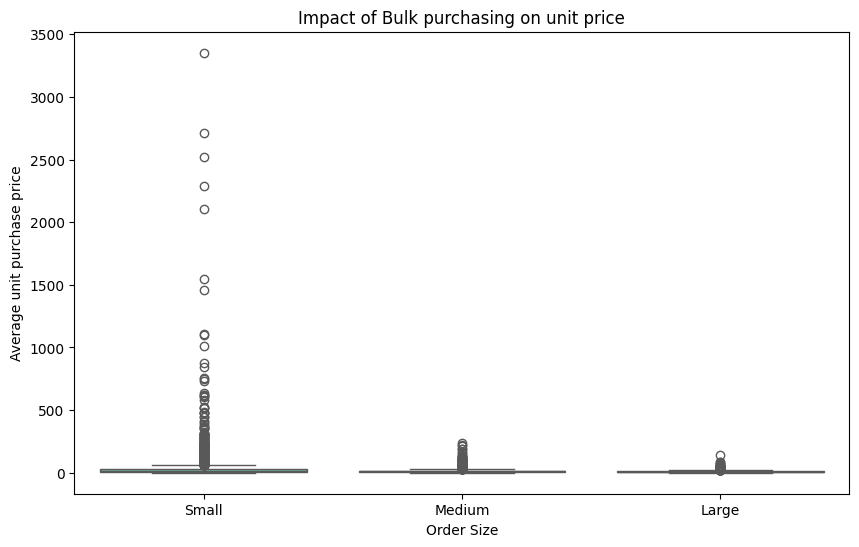

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", palette='Set2')
plt.title("Impact of Bulk purchasing on unit price")
plt.xlabel("Order Size")
plt.ylabel("Average unit purchase price")
plt.show()

<li>Vendor buying in bulk(large order size) get the lowest unit price($10.78 per unit), meaning higher margins if they can manage inventory efficiently.</li>
<li>The Price between small and large order is substanial (~72% reduction in unit cost)</li>
<li>This suggests that bulk pricing strategies successfully vendors to purchase in larger volumes, leading to higher overall sales despite lower per unit revenue.</li>

### Business Problem 6: Which vendor have low inventory turnover, including excess stock and slow-moving products

In [44]:
df[df['StockTurnover'] < 1]\
  .groupby('VendorName')[['StockTurnover']]\
  .mean()\
  .sort_values(by='StockTurnover', ascending=True).head(10)

,StockTurnover
VendorName,
ALISA CARR BEVERAGES,0.615385
HIGHLAND WINE MERCHANTS LLC,0.708333
PARK STREET IMPORTS LLC,0.751306
Circa Wines,0.755676
Dunn Wine Brokers,0.766022
CENTEUR IMPORTS LLC,0.773953
SMOKY QUARTZ DISTILLERY LLC,0.783835
TAMWORTH DISTILLING,0.797078
THE IMPORTED GRAPE LLC,0.807569


### Business Problem 7: How much capital is locked in unsold inventory per vendor, and which vendors contribute the most to it?

In [46]:
df["UnsoldInventoryValue"] = (df["TotalPurchaseQuantity"] - df["TotalSalesQuantity"]) * df["PurchasePrice"]
print('Total Unsold Capital:', format_dollars(df["UnsoldInventoryValue"].sum()))


Total Unsold Capital: 2.71M


### Business Problem 8: What is the 95% confidence intervals for profit margins of top-performing and low-performing vendors 

In [45]:
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)


In [47]:
top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

In [48]:
top_vendors

0       25.297693
1       21.062810
2       24.675786
3       27.139908
4       28.412764
          ...    
3523    79.684817
3681    85.782102
4751    93.085860
4920    95.012530
5050    94.271857
Name: ProfitMargin, Length: 2142, dtype: float64

In [49]:
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))  # Standard error
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)
    margin_of_error = t_critical * std_err
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error

Top Vendors 95% CI: (30.74, 31.61), Mean: 31.17
Low Vendors 95% CI: (40.48, 42.62), Mean: 41.55


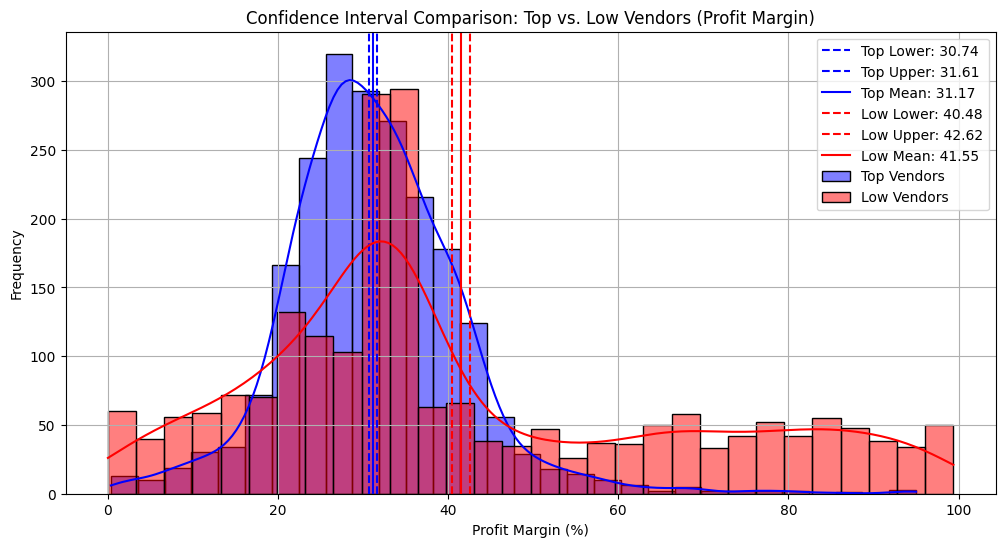

In [50]:
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

plt.figure(figsize=(12, 6))

# Top Vendors Plot
sns.histplot(top_vendors, kde=True, color="blue", bins=30, alpha=0.5, label="Top Vendors")
plt.axvline(top_lower, color="blue", linestyle="--", label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color="blue", linestyle="--", label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color="blue", linestyle="-", label=f"Top Mean: {top_mean:.2f}")

# Low Vendors Plot
sns.histplot(low_vendors, kde=True, color="red", bins=30, alpha=0.5, label="Low Vendors")
plt.axvline(low_lower, color="red", linestyle="--", label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color="red", linestyle="--", label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color="red", linestyle="-", label=f"Low Mean: {low_mean:.2f}")

# Finalize Plot
plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

### Key Insights on Vendor Performance and Margins

- **Confidence Intervals Comparison**:
  - Low-performing vendors: 40.48% to 42.62%
  - Top-performing vendors: 30.74% to 31.61%  
  *(Note: Low performers have significantly higher margins.)*

- **Interpretation**:
  - Vendors with lower sales maintain higher Biofit margins, possibly due to:  
    - Premium pricing strategies  
    - Lower operational costs  

- **Recommendations for High-Performing Vendors** (to improve profitability):  
  - Selective price adjustments  
  - Cost optimization  
  - Bundling strategies  

- **Recommendations for Low-Performing Vendors** (despite higher margins):  
  - Enhance marketing efforts  
  - Competitive pricing adjustments  
  - Improved distribution strategies  

In [51]:
# Python Script to Export Table as CSV
import pandas as pd
from sqlalchemy import create_engine

# Create connection to SQLite database
engine = create_engine('sqlite:///inventory.db')

# Read the vendor_sales_summary table into a DataFrame
df = pd.read_sql('SELECT * FROM vendor_sales_summary', con=engine)

In [52]:
# Export DataFrame to CSV
df.to_csv('vendor_sales_summary.csv', index=False)

print("Export successful: vendor_sales_summary.csv")

Export successful: vendor_sales_summary.csv


<center>

## <u>Connect with Me</u>

<div style="font-family: 'Times New Roman', Times, serif; font-size: 16px; line-height: 2; text-align: center;">
    <a href="mailto:hritishx@gmail.com">Email Me</a><br>
    <a href="https://www.linkedin.com/in/hritish-mahajan/">LinkedIn</a><br>
    <a href="https://github.com/hritishmahajan">GitHub</a>
</div>

<br>

<div style="font-family: 'Times New Roman', Times, serif; font-size: 16px; padding: 12px;">
    Made with <span style="color: #e25555;">❤️</span> by <strong>Hritish Mahajan</strong><br>
</div>

</center>
